## Burgers' Equation

- Data:
  - https://github.com/rezaakb/pinns-torch/blob/main/pinnstorch/utils/utils.py

### Problem

Solve Burgers' equation:

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial t} - \nu\frac{\partial^2 u}{\partial t^2} = 0, \quad\nu=\frac{0.01}{\pi}, \quad x\in [-1, 1],\quad t\in [0, 1]$$

- Initial conditon:

$$u(x, 0) = -\sin(\pi x)$$

- Boundary conditions:

$$u(-1, t) = 0,\quad u(1, t) = 0$$

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import torch
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings(action="ignore")

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data

In [17]:
import scipy

data = scipy.io.loadmat('data/burgers_shock.mat')
x_np = data['x'].squeeze()     # (256, 1) -> (256,)
t_np = data['t'].squeeze()     # (100, 1) -> (100, )
U_np = data['usol']            # (256, 100)
print(">> Data:", x_np.shape, t_np.shape, U_np.shape)

x_min, x_max, x_size = x_np.min(), x_np.max(), x_np.size
t_min, t_max, t_size = t_np.min(), t_np.max(), t_np.size
print(">> x:", x_min, x_max, x_size)
print(">> t:", t_min, t_max, t_size)

X_np, T_np = np.meshgrid(x_np, t_np, indexing="ij")
print(">> X, T:", X_np.shape, T_np.shape)

>> Data: (256,) (100,) (256, 100)
>> x: -1.0 1.0 256
>> t: 0.0 0.99 100
>> X, T: (256, 100) (256, 100)


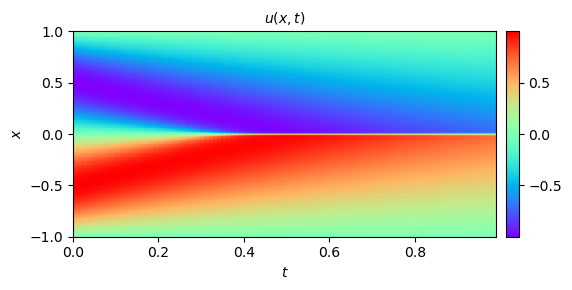

In [18]:
fig, ax = plt.subplots(figsize=(6, 3))
h = ax.imshow(U_np, interpolation='nearest', cmap='rainbow', 
            extent=[T_np.min(), T_np.max(), X_np.min(), X_np.max()], 
            origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
fig.colorbar(h, cax=cax)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('$u(x,t)$', fontsize = 10)

fig.tight_layout()
plt.show()

In [20]:
## Collocation points
from pyDOE import lhs         #Latin Hypercube Sampling

n_train = 1000
lb, ub = np.array([x_min, t_min]), np.array([x_max, t_max])
points = lb + (ub - lb)*lhs(2, n_train)
x_train_np, t_train_np = points[:, 0], points[:, 1]
print(">> Train:", x_train_np.shape, t_train_np.shape)

## test points
x_test_np, t_test_np, u_test_np = X_np.flatten(), T_np.flatten(), U_np.flatten()
print(">> Test:", x_test_np.shape, t_test_np.shape, u_test_np.shape)

>> Train: (1000,) (1000,)
>> Test: (25600,) (25600,) (25600,)


### Model

In [65]:
def gradient(y, x):
    return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y),
                               retain_graph=True, create_graph=True)[0]

def residual_loss(model, x, t):
    x.requires_grad = True  # 1D tensor
    t.requires_grad = True  # 1D tensor
    u = model(x, t)
    u_t = gradient(u, t)
    u_x = gradient(u, x)
    u_xx = gradient(u_x, x)
    residual = u_t + u*u_x - (0.01/np.pi)*u_xx
    return torch.mean(residual**2)

x = torch.linspace(x_min, x_max, x_size).float().to(device)
t = torch.linspace(t_min, t_max, t_size).float().to(device)

## Initial condition: u(x, 0) = -sin(pi * x)
left_x = x
left_t = torch.full_like(x, 0)
left_u = -torch.sin(torch.pi * x)

## Boundary condition: u(-1, t) = 0
bottom_x = torch.full_like(t, -1)
bottom_t = t
bottom_u = torch.full_like(t, 0)

## Boundary contition: u(1, t) = 0
top_x = torch.full_like(t, 1)
top_t = t
top_u = torch.full_like(t, 0)

## Collocation points: x in [-1, 1], t in [0, 1]
x_train = torch.tensor(x_train_np).float().to(device)
t_train = torch.tensor(t_train_np).float().to(device)

x_test = torch.tensor(x_test_np).float().to(device)
t_test = torch.tensor(t_test_np).float().to(device)
u_test = torch.tensor(u_test_np).float().to(device)

In [66]:
class MLP(nn.Module):
    def __init__(self, layer_sizes, activation, final_activation=None):
        super().__init__()
        self.input_size = layer_sizes[0]
        self.output_size = layer_sizes[-1]

        layers = []
        for i in range(len(layer_sizes) - 2):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            layers.append(activation)
        layers.append(nn.Linear(layer_sizes[-2], layer_sizes[-1]))
        if final_activation is not None:
            layers.append(final_activation)
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
    
class PINN(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.model = MLP(layer_sizes, activation=nn.Tanh())
        
    def forward(self, x, t):
        inputs = torch.concat([x.unsqueeze(-1), t.unsqueeze(-1)], dim=-1)
        return self.model(inputs).squeeze()

In [67]:
model = PINN(layer_sizes=[2, 50, 50, 50, 50, 1]).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.985)

n_epochs = 10000
for epoch in range(1, n_epochs + 1):
    model.train()
    loss_eqn = residual_loss(model, x_train, t_train)
    loss_left = loss_fn(model(left_x, left_t), left_u)
    loss_bottom = loss_fn(model(bottom_x, bottom_t), bottom_u)
    loss_top = loss_fn(model(top_x, top_t), top_u)

    loss = loss_eqn + loss_left + loss_bottom + loss_top
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()

    model.eval()
    with torch.no_grad():
        loss_test = loss_fn(model(x_test, t_test), u_test)

    if epoch % (n_epochs // 10) == 0:
        print(f"[{epoch:5d}/{n_epochs}] (lr: {scheduler.get_last_lr()[0]:.2e}) "
              f"loss: {loss.item():.2e} "
              f"(eqn: {loss_eqn.item():.2e} left: {loss_left.item():.2e} "
              f"bottom: {loss_bottom.item():.2e} top: {loss_top.item():.2e}) "
              f"| test_loss: {loss_test.item():.2e}")

[ 1000/10000] (lr: 8.60e-04) loss: 9.51e-02 (eqn: 4.13e-02 left: 5.28e-02 bottom: 6.25e-04 top: 3.65e-04) | test_loss: 7.66e-02
[ 2000/10000] (lr: 7.39e-04) loss: 8.13e-02 (eqn: 3.45e-02 left: 4.66e-02 bottom: 2.47e-04 top: 6.73e-05) | test_loss: 6.48e-02
[ 3000/10000] (lr: 6.35e-04) loss: 6.56e-02 (eqn: 2.67e-02 left: 3.86e-02 bottom: 2.40e-04 top: 5.01e-05) | test_loss: 5.13e-02
[ 4000/10000] (lr: 5.46e-04) loss: 4.21e-02 (eqn: 1.89e-02 left: 2.26e-02 bottom: 3.55e-04 top: 1.80e-04) | test_loss: 2.88e-02
[ 5000/10000] (lr: 4.70e-04) loss: 1.50e-02 (eqn: 6.98e-03 left: 7.93e-03 bottom: 6.00e-05 top: 3.32e-05) | test_loss: 7.37e-03
[ 6000/10000] (lr: 4.04e-04) loss: 5.86e-03 (eqn: 3.38e-03 left: 2.43e-03 bottom: 2.80e-05 top: 2.41e-05) | test_loss: 2.21e-03
[ 7000/10000] (lr: 3.47e-04) loss: 3.23e-03 (eqn: 2.17e-03 left: 9.79e-04 bottom: 6.78e-05 top: 2.11e-05) | test_loss: 1.51e-03
[ 8000/10000] (lr: 2.98e-04) loss: 1.58e-03 (eqn: 1.03e-03 left: 5.20e-04 bottom: 1.58e-05 top: 8.07e-06

In [68]:
model.eval()
with torch.no_grad():
    U_pred = model(x_test, t_test)
    
U_pred_np = U_pred.cpu().detach().numpy().reshape(x_size, t_size)
U_pred_np.shape

(256, 100)

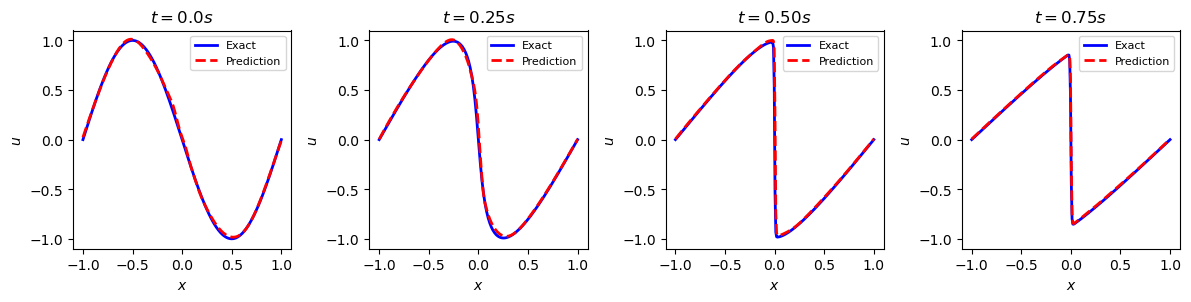

In [82]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(12, 3))
ax0.plot(x_np, U_np[:, 0], 'b-', lw=2, label='Exact')
ax0.plot(x_np, U_pred_np[:, 0], 'r--', lw=2, label='Prediction')
ax0.set_title('$t = 0.0s$')

ax1.plot(x_np, U_np[:, 25], 'b-', lw=2, label='Exact')
ax1.plot(x_np, U_pred_np[:, 25], 'r--', lw=2, label='Prediction')
ax1.set_title('$t = 0.25s$')

ax2.plot(x_np, U_np[:, 50], 'b-', lw=2, label='Exact')
ax2.plot(x_np, U_pred_np[:, 50], 'r--', lw=2, label='Prediction')
ax2.set_title('$t = 0.50s$')

ax3.plot(x_np, U_np[:, 75], 'b-', lw=2, label='Exact')
ax3.plot(x_np, U_pred_np[:, 75], 'r--', lw=2, label='Prediction')
ax3.set_title('$t = 0.75s$')

for ax in (ax0, ax1, ax2, ax3):
    ax.legend(fontsize=8)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u$')
    ax.axis('square')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    
fig.tight_layout()
plt.show()

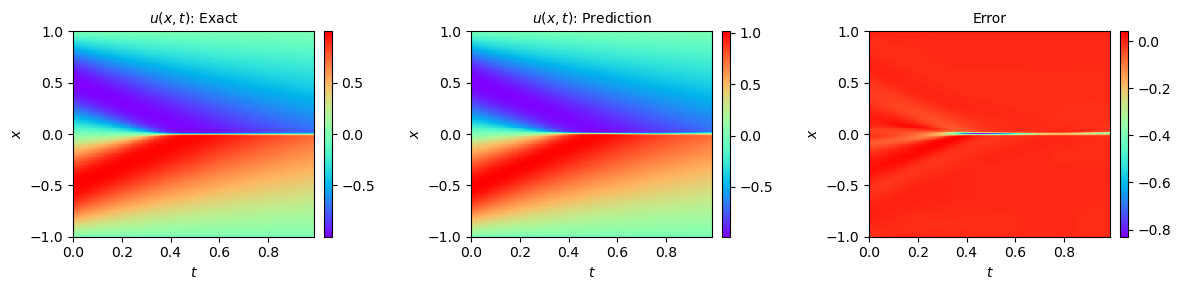

In [81]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 3))
h1 = ax1.imshow(U_np, interpolation='nearest', cmap='rainbow', 
            extent=[T_np.min(), T_np.max(), X_np.min(), X_np.max()], 
            origin='lower', aspect='auto')
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="3%", pad=0.1)
fig.colorbar(h1, cax=cax1)

h2 = ax2.imshow(U_pred_np, interpolation='nearest', cmap='rainbow', 
            extent=[T_np.min(), T_np.max(), X_np.min(), X_np.max()], 
            origin='lower', aspect='auto')
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="3%", pad=0.1)
fig.colorbar(h2, cax=cax2)

h3 = ax3.imshow(U_np - U_pred_np, interpolation='nearest', cmap='rainbow', 
            extent=[T_np.min(), T_np.max(), X_np.min(), X_np.max()], 
            origin='lower', aspect='auto')
divider3 = make_axes_locatable(ax3)
cax3 = divider3.append_axes("right", size="3%", pad=0.1)
fig.colorbar(h3, cax=cax3)

ax1.set_title('$u(x,t)$: Exact', fontsize = 10)
ax2.set_title('$u(x,t)$: Prediction', fontsize = 10)
ax3.set_title('Error', fontsize = 10)

for ax in (ax1, ax2, ax3):
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')

fig.tight_layout()
plt.show()